# Klasifikasi Gambar menggunakan CNN

Notebook ini merupakan bagian dari buku **Machine Learning menggunakan Python** oleh **Fahmi Noor Fiqri**. Notebook ini berisi contoh kode untuk **BAB XIII - CONVOLUTIONAL NEURAL NETWORK**

In [1]:
# Import library
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
epochs = 100
batch_size = 128
random_seed = 42

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Data Understanding

In [3]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

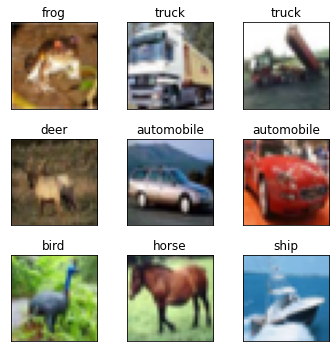

In [4]:
fig = plt.figure(figsize=(5, 5))
samples = zip(X_train[:9], y_train[:9])
for i, (img, class_index) in enumerate(samples):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

    label = class_names[class_index[0]]
    ax.set_title(label)

fig.tight_layout()
plt.grid(False)

## Data Preparation

In [5]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')

In [6]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-03-09 15:03:30.004493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-09 15:03:30.037263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-09 15:03:30.037698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-09 15:03:30.038361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

In [7]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

In [8]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(X_train.shape[0])
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [9]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Modelling

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [11]:
# Kompilasi model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [12]:
# Lakukan training menggunakan data latih
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
H = model.fit(ds_train, validation_data=ds_test, epochs=epochs, callbacks=[early_stopping])

Epoch 1/100


2022-03-09 15:03:33.070091: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-09 15:03:35.309430: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-03-09 15:03:36.390131: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-09 15:03:36.429351: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-09 15:03:36.429410: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-09 15:03:36.464803: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-09 15:03:36.464913: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

391/391 [==============================] - 11s 13ms/step - loss: 1.7192 - accuracy: 0.4716 - val_loss: 2.2528 - val_accuracy: 0.3077
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 1.1243 - accuracy: 0.6252 - val_loss: 1.0800 - val_accuracy: 0.6387
Epoch 3/100
391/391 [==============================] - 4s 11ms/step - loss: 0.9370 - accuracy: 0.6830 - val_loss: 1.0317 - val_accuracy: 0.6593
Epoch 4/100
391/391 [==============================] - 4s 11ms/step - loss: 0.8199 - accuracy: 0.7203 - val_loss: 0.8315 - val_accuracy: 0.7109
Epoch 5/100
391/391 [==============================] - 4s 11ms/step - loss: 0.7464 - accuracy: 0.7437 - val_loss: 0.8380 - val_accuracy: 0.7104
Epoch 6/100
391/391 [==============================] - 4s 11ms/step - loss: 0.6908 - accuracy: 0.7602 - val_loss: 0.7943 - val_accuracy: 0.7237
Epoch 7/100
391/391 [==============================] - 4s 11ms/step - loss: 0.6439 - accuracy: 0.7765 - val_loss: 1.1188 - val_accuracy: 0.6519
Epo

## Evaluation

In [13]:
# Lakukan prediksi 
y_pred = model.predict(ds_test)
y_pred = np.argmax(y_pred, axis=1)

# Hitung statistik prediksi
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.86      0.77      0.81      1000
  automobile       0.89      0.91      0.90      1000
        bird       0.71      0.70      0.71      1000
         cat       0.65      0.69      0.67      1000
        deer       0.81      0.74      0.77      1000
         dog       0.66      0.79      0.72      1000
        frog       0.83      0.89      0.86      1000
       horse       0.91      0.81      0.86      1000
        ship       0.93      0.85      0.89      1000
       truck       0.85      0.89      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.81     10000
weighted avg       0.81      0.80      0.81     10000



<Figure size 720x720 with 0 Axes>

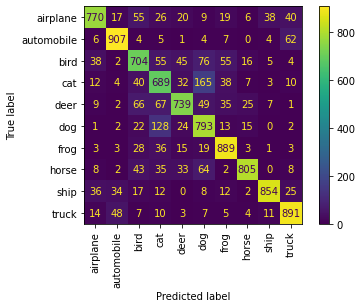

In [26]:
# Tampilkan confusion matrix
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), y_pred, display_labels=class_names, xticks_rotation="vertical")

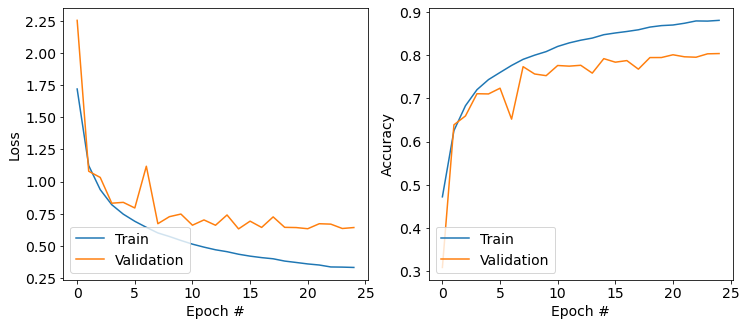

In [28]:
# Tampilkan statistik training model
plt.rc('font', size=14)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(H.history["loss"], label="Train")
ax1.plot(H.history["val_loss"], label="Validation")
ax1.set_xlabel("Epoch #")
ax1.set_ylabel("Loss")
ax1.legend(loc="lower left")

ax2.plot(H.history["accuracy"], label="Train")
ax2.plot(H.history["val_accuracy"], label="Validation")
ax2.set_xlabel("Epoch #")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower left")

Text(0.5, 1.0, 'Prediksi: cat')

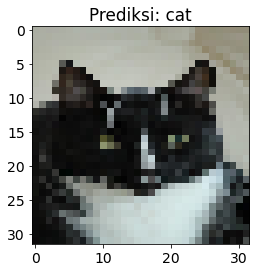

In [30]:
# Lakukan prediksi
pred_img = tf.keras.preprocessing.image.load_img('../datasets/kucing.jpg', target_size=(32, 32))
pred_img = tf.keras.preprocessing.image.img_to_array(pred_img)
pred_img = pred_img / 255.0
pred_img = np.expand_dims(pred_img, axis=0)

predicted = model.predict(pred_img)
predicted = np.argmax(predicted, axis=1)[0]
inv_map = {k: v for k, v in enumerate(class_names)}
inv_map[predicted]

plt.imshow(pred_img[0])
plt.title("Prediksi: " + inv_map[predicted])

## Persistance

In [20]:
import os
import joblib

# Simpan pemetaan kelas
inv_map = {k: v for k, v in enumerate(class_names)}
joblib.dump(inv_map, '../model/cifar10_dict.joblib')

# Simpan model
os.mkdir('../model/cifar10_classify')
model.save('../model/cifar10_classify')

2022-03-09 15:06:22.376230: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model/cifar10_classify/assets
